In [100]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
## Generate Dummy Data
dummy_data, dummy_labels = make_blobs(n_samples=100, n_features=12, centers=4, shuffle=True, random_state=0)
pd.concat([pd.DataFrame(dummy_data), pd.DataFrame(dummy_labels)], axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,0
0,1.230784,8.605886,-7.636233,-10.997091,-10.164944,6.922301,5.096289,5.983337,10.441330,6.260043,-1.741517,5.925401,1
1,-8.553625,2.991174,-7.497989,7.102051,0.378380,-2.024304,-6.341311,5.417540,0.612363,1.889983,-9.012277,1.011213,2
2,2.004206,6.941309,-8.786183,-7.377235,-11.293738,7.039677,3.307571,6.377736,9.610997,4.326456,-1.755923,4.138749,1
3,-7.559925,1.721321,-7.557598,8.063414,1.848138,-0.920957,-4.766357,5.093457,0.063924,1.773883,-9.126152,2.326518,2
4,0.281702,4.154153,1.620114,2.746927,-0.854609,3.325344,-2.018172,8.374709,8.598923,-2.299339,5.198655,1.254332,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.115044,6.213852,1.787264,1.700120,-0.579652,2.762872,-0.634176,8.757667,9.649681,-3.430570,6.132739,1.904284,0
96,-6.308050,1.833814,-7.073040,8.680855,-0.325148,-2.594541,-3.772489,4.959033,-0.605823,0.567182,-10.271385,2.824957,2
97,0.578262,8.401543,-9.633907,-7.437166,-9.132502,6.931493,5.902039,9.421287,9.103503,3.781730,-0.571113,5.559980,1
98,-9.458768,3.102024,-6.360239,7.231780,0.885162,-0.010580,-4.723745,6.306080,-0.206423,0.661173,-9.584437,0.785715,2


In [113]:
## Implement KMeans Clustering
km = KMeans(n_clusters=4, init='random', n_init=10, max_iter=30, tol=1e-04, random_state=0)
y_km = km.fit_predict(dummy_data)
print(y_km)

[3 2 3 2 0 0 1 0 1 2 0 2 0 3 3 1 1 3 0 1 2 1 1 3 0 3 2 3 0 2 3 1 1 0 2 1 2
 2 0 2 1 2 3 3 1 2 0 1 2 2 2 3 0 2 3 3 2 3 0 1 3 0 2 0 0 1 2 1 1 1 3 1 3 1
 1 0 1 0 2 3 1 3 0 0 3 0 2 0 2 0 3 3 0 1 1 0 2 3 2 3]


## Spherical Kmeans

In [114]:
## Assign random labels to each pixel
K = 4 # K is the number of clusters that we want to create 

label_arr = np.zeros(len(dummy_data), dtype=np.uint8)
for i in range(len(label_arr)):
    label_arr[i] = np.random.choice(K)
#print(np.unique(label_arr, return_counts=True))

In [115]:
## Cosine similarity between two vectors
def similarity(vec1, vec2):
    vec1 = np.ravel(vec1)
    vec1 = vec1/np.linalg.norm(vec1)
    
    vec2 = np.ravel(vec2)
    vec2 = vec2/np.linalg.norm(vec2)
    
    angle = np.dot(vec1, vec2)
    return angle

In [116]:
## Generate new centriods from updated labels
def mean_update(K,data,label_arr,prev_mean=None): # previous mean is None when mean is initialized for the first time
    mean_ls = [] # List containing mean values of the clusters
    data_ls = [[] for k in range(K)]  # Create list of empty lists to store data belonging to a certain cluster
    
    for i in range(len(label_arr)):
        for k in range(K):
            if label_arr[i] == k: # if the label of the data at location i is 'k'
                data_ls[k].append(np.ravel(data[i,:])) ## Fill the kth empty list with this data row
                    
    for k in range(K):
        if len(data_ls[k]) != 0:  # Only update the means of those clusters which has received at least one new point, else retain the old mean value
            data_k_matrix = np.matrix(data_ls[k])
            mean_k = np.mean(data_k_matrix,axis=0)
            mean_ls.append(np.ravel(mean_k))
        else:
            mean_ls.append(prev_mean[k])
    return(mean_ls)

In [117]:
## Function to update labels from previous mean
def label_update(mean_arr,data):
    labels = []
    for i in range(data.shape[0]):
        cosine_dist_ls = [] 
        for k in range(len(mean_arr)):
            distance = similarity(data[i,:],mean_arr[k]) # Calculate the similarity of the data at i with the kth mean
            cosine_dist_ls.append(distance) # Put the distance values in a list
        dist_arr = np.array(cosine_dist_ls) # Convert it to a NumPy array
        new_label = np.argmax(dist_arr) #The new_label of the point is the one which is closest to the data at i
        labels.append(new_label) # Set the new label
    return(np.array(labels))

In [118]:
## Define Spherical KMeans Algorithm
def Spherical_KMeans(K,data,label_arr,maxIter):
    mean_old = mean_update(K,data,label_arr)
    for t in range(maxIter):
        new_label_arr = label_update(mean_old,data)
        mean_new = mean_update(K,data,new_label_arr,mean_old)
        print("The mean obtained at {}th iteration is {}\n".format(t,np.matrix(mean_new)))
        label_arr = new_label_arr ## Update the label array
        mean_old = mean_new ## Update the mean values
    return(mean_new,label_arr)

In [119]:
mean_cent, y_skm = Spherical_KMeans(K, dummy_data, label_arr, 5)

The mean obtained at 0th iteration is [[ 0.0629138   3.48267893  2.0070556   1.96850096 -1.86602281  2.65589894
  -1.61464308  7.32235029  9.50034295 -3.05091196  4.85419329 -0.50415293]
 [-8.01772081  2.90973124 -6.98203448  8.86363821  0.1511709  -1.79862378
  -4.54442275  5.36639686 -0.93082544  1.14195052 -9.55118998  2.13946537]
 [ 2.46523048  2.59591955  8.26691596  3.31720475 -2.53249507 -0.74459837
   3.85353967 -7.00842997  4.03028195  2.87038165 -4.2995689  -6.52798647]
 [ 1.11854185  6.29261128 -4.03153034 -4.20110111 -6.12528608  4.83215562
   2.29869618  7.66678472  9.33570534  2.22448627  1.96166142  3.68087133]]

The mean obtained at 1th iteration is [[ 0.8790256   4.09905424  1.77650422  1.33955728 -1.74327572  2.91949603
  -1.54979883  7.90140876  9.26174945 -2.3241968   5.76088376  0.73131433]
 [-8.01772081  2.90973124 -6.98203448  8.86363821  0.1511709  -1.79862378
  -4.54442275  5.36639686 -0.93082544  1.14195052 -9.55118998  2.13946537]
 [ 2.66778729  2.30400795  8

In [120]:
print(y_skm)

[3 1 3 1 0 0 2 0 2 1 0 1 0 3 3 2 2 3 0 2 1 2 2 3 0 3 1 3 0 1 3 2 2 0 1 2 1
 1 0 1 2 1 3 3 2 1 0 2 1 1 1 3 0 1 3 3 1 3 0 2 3 0 1 0 0 2 1 2 2 2 3 2 3 2
 2 0 2 0 1 3 2 3 0 0 3 0 1 0 1 0 3 3 0 2 2 0 1 3 1 3]


In [121]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dummy_data)
pd.DataFrame(principalComponents)

,0,1
0,17.245120,-5.669253
1,-4.187427,15.969789
2,15.301316,-3.564037
3,-4.548711,15.922921
4,3.260966,-0.664959
...,...,...
95,4.750413,-1.680824
96,-5.211161,15.534799
97,17.594340,-1.995701
98,-4.315383,15.895941


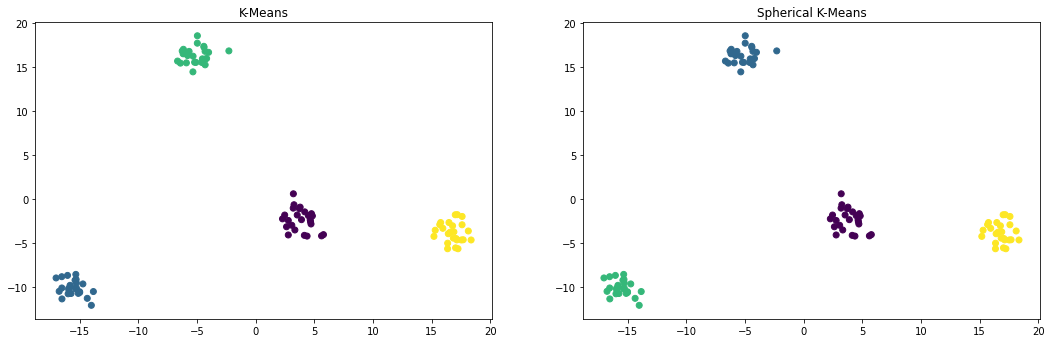

In [122]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=y_km)
plt.title("K-Means")
plt.subplot(2,2,2)
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=y_skm)
plt.title("Spherical K-Means")
plt.show()